
## **Feature Extraction (Özellik Çıkarımı)**

* Ham veriden değişken - özellik - feature üretmek demektir.

**1. Yapısal verilerden değişkenler türetmek:** belirli yapıda olan mevcut değişkenler üzerinden yeni veri türetmek demektir. Aşağıdaki şekilde görüldüğü gibi Timestamp değişkeninden yıl, ay, gün, saat ve gün bilgileri türetilmiştir. 

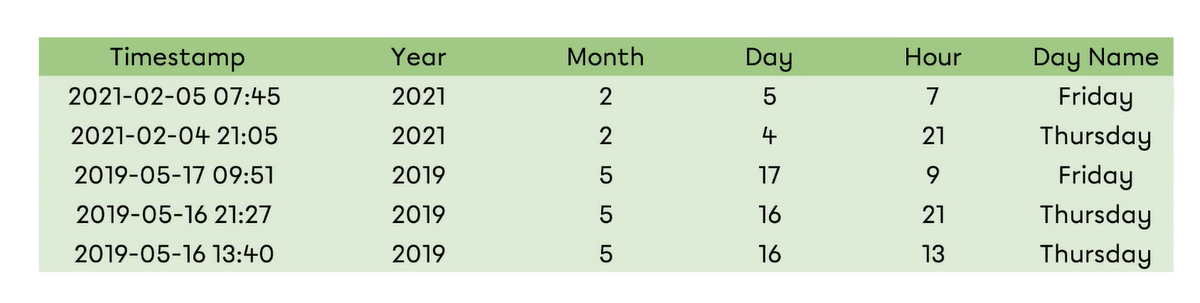


**2. Yapısal olmayan verilerden değişkenler türetmek:** görüntü, ses, video, yazı gibi.. Yapısal olmayan görüntü verisi matematiksel temsiller ile ifade edilmiştir.

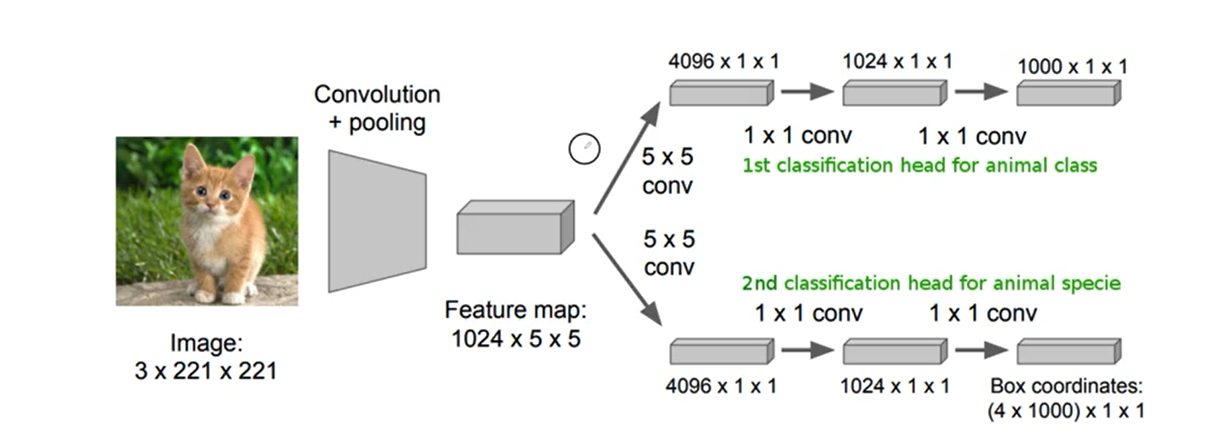

### **Binary Features:** Flag - Bool - True-False

* İş problemine göre kullanılacak yöntemler değişmekle birlikte buradaki amacımız, var olan değişkenler üzerinden 0-1 şeklinde yeni değişkenler türetmektir. 

In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

import missingno as msno
from datetime import date
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
pd.set_option("display.float_format", lambda x: "%.3f" % x)
pd.set_option("display.width", 500)

In [3]:
df = pd.read_csv("/content/gdrive/MyDrive/DSMLBC10/week_9 (24.11.22-30.11.22)/feature_engineering/datasets/titanic.csv")
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000,1,0,A/5 21171,7.250,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000,1,0,PC 17599,71.283,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000,0,0,STON/O2. 3101282,7.925,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000,1,0,113803,53.100,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.000,0,0,373450,8.050,NaN,S


In [4]:
df["NEW_CABIN_BOOL"] = df["Cabin"].notnull().astype('int')

# isimlendirme olarak bool kullanılmıştır fakat flag, true-false da yazabilirsin.

In [5]:
df["NEW_CABIN_BOOL"].head()

0    0
1    1
2    0
3    1
4    0
Name: NEW_CABIN_BOOL, dtype: int64

In [6]:
df.groupby("NEW_CABIN_BOOL").agg({"Survived": "mean"})

,Survived
NEW_CABIN_BOOL,
0,0.300
1,0.667


$\star$ **Normalde çöp olarak değerlendirilen kabin değeri bir anda anlamlı hale geldi. Kabin numarası olanların hayatta kalma oranı çok yüksek oldu.**

In [7]:
from statsmodels.stats.proportion import proportions_ztest
# count : başarı sayısı,
# nobs : gözlem sayısı
test_stat, pvalue = proportions_ztest(count=[df.loc[df["NEW_CABIN_BOOL"] == 1, "Survived"].sum(),
                                             df.loc[df["NEW_CABIN_BOOL"] == 0, "Survived"].sum()],

                                      nobs=[df.loc[df["NEW_CABIN_BOOL"] == 1, "Survived"].shape[0],
                                            df.loc[df["NEW_CABIN_BOOL"] == 0, "Survived"].shape[0]])

print('Test Stat = %.4f, p-value = %.4f' % (test_stat, pvalue))

Test Stat = 9.4597, p-value = 0.0000


* H0 Hipotezi: İki oran arasında istatistiksel olarak anlamlı bir farklılık yok der.

* pvalue değeri 0.05 den küçük olduğı için H0 hipotezi red edilir. Yani aralarında istatistiksel olarak anlamlı bir farklılık var gibi gözükmektedir.

* Modelleme yapmadan tam anlamıyla göremem ama fikir vermesini sağlayabilirim. 

* Survived değişkeni NEW_CABIN_BOOL değişkeninden mi ortaya çıkmış bunu bilmiyorum. Bu yapılar tek başına ortaya çıkmadı yada çıkmışta olabilir. Şuanki çıkarımımız çıkmış olabileceğine yöneliktir. Burada **<u>çok değişkenli etkiyi de incelemek gerekir.</u>**

In [8]:
#gemidekilerin akrabalıklarını inceleyen iki değişkeni inceliyoruz.
df.loc[((df['SibSp'] + df['Parch']) > 0), "NEW_IS_ALONE"] = "NO"
df.loc[((df['SibSp'] + df['Parch']) == 0), "NEW_IS_ALONE"] = "YES"

df.groupby("NEW_IS_ALONE").agg({"Survived": "mean"})

,Survived
NEW_IS_ALONE,
NO,0.506
YES,0.304


In [9]:
test_stat, pvalue = proportions_ztest(count=[df.loc[df["NEW_IS_ALONE"] == "YES", "Survived"].sum(),
                                             df.loc[df["NEW_IS_ALONE"] == "NO", "Survived"].sum()],

                                      nobs=[df.loc[df["NEW_IS_ALONE"] == "YES", "Survived"].shape[0],
                                            df.loc[df["NEW_IS_ALONE"] == "NO", "Survived"].shape[0]])

print('Test Stat = %.4f, p-value = %.4f' % (test_stat, pvalue))

Test Stat = -6.0704, p-value = 0.0000


* H0 Hipotezi: iki oran arasında istatistiksel olarak anlamlı bir farklılık yok der.

* pvalue değeri 0.05 den küçük olduğı için H0 hipotezi red edilir. Yani aralarında istatistiksel olarak anlamlı bir farklılık var gibi gözükmektedir.

* Mutlak olarak hayatta kalma durumunu bu değişkenin etkilediğini göstermez fakat bu değişkenin gözardı edilemeyeceğini gösterir. Model kurulduğunda bu etki daha net belli olacaktır.

### **Text'ler Üzerinden Özellik Türetmek**

####  **Letter Count**

In [10]:
#bir değişkende kaç tane harf var ise onu sayar.

df["NEW_NAME_COUNT"] = df["Name"].str.len()

In [11]:
df["NEW_NAME_COUNT"].head()

0    23
1    51
2    22
3    44
4    24
Name: NEW_NAME_COUNT, dtype: int64

#### **Word Count**

In [12]:
#bir değişkende kaç tane kelime var ise onu sayar.

df["NEW_NAME_WORD_COUNT"] = df["Name"].apply(lambda x: len(str(x).split(" ")))

In [13]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,NEW_CABIN_BOOL,NEW_IS_ALONE,NEW_NAME_COUNT,NEW_NAME_WORD_COUNT
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000,1,0,A/5 21171,7.250,NaN,S,0,NO,23,4
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000,1,0,PC 17599,71.283,C85,C,1,NO,51,7
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000,0,0,STON/O2. 3101282,7.925,NaN,S,0,YES,22,3
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000,1,0,113803,53.100,C123,S,1,NO,44,7
4,5,0,3,"Allen, Mr. William Henry",male,35.000,0,0,373450,8.050,NaN,S,0,YES,24,4


#### **Özel Yapıları Yakalamak**

In [14]:
df["NEW_NAME_DR"] = df["Name"].apply(lambda x: len([x for x in x.split() if x.startswith("Dr")]))

df.groupby("NEW_NAME_DR").agg({"Survived": ["mean","count"]})

Survived      
                mean count
NEW_NAME_DR               
0              0.383   881
1              0.500    10

* Olası tüm featureları çıkar modelleme basamağında değerlendirilir. Normalde meslek yok ama DR. unvanına sahipleri bir flagleyelim.

* Mümkün olan az değişkenle yüksek başarılara erişmeye çalış.

* Doktor olanların hayatta kalma oranları daha yüksek çıktı. Fakat sayısına da bakmayı unutma 10 tane imiş.

* Önemli mi değil mi yoruma açık olmakla birlikte en azından kayda değerdir, dursun diyoruz.

#### **Regex ile Değişken Türetmek**

In [15]:
df['NEW_TITLE'] = df.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,NEW_CABIN_BOOL,NEW_IS_ALONE,NEW_NAME_COUNT,NEW_NAME_WORD_COUNT,NEW_NAME_DR,NEW_TITLE
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000,1,0,A/5 21171,7.250,NaN,S,0,NO,23,4,0,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000,1,0,PC 17599,71.283,C85,C,1,NO,51,7,0,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000,0,0,STON/O2. 3101282,7.925,NaN,S,0,YES,22,3,0,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000,1,0,113803,53.100,C123,S,1,NO,44,7,0,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.000,0,0,373450,8.050,NaN,S,0,YES,24,4,0,Mr


In [16]:
df[["NEW_TITLE", "Survived", "Age"]].groupby(["NEW_TITLE"]).agg({"Survived": "mean", "Age": ["count", "mean"]})

Survived   Age       
              mean count   mean
NEW_TITLE                      
Capt         0.000     1 70.000
Col          0.500     2 58.000
Countess     1.000     1 33.000
Don          0.000     1 40.000
Dr           0.429     6 42.000
Jonkheer     0.000     1 38.000
Lady         1.000     1 48.000
Major        0.500     2 48.500
Master       0.575    36  4.574
Miss         0.698   146 21.774
Mlle         1.000     2 24.000
Mme          1.000     1 24.000
Mr           0.157   398 32.368
Mrs          0.792   108 35.898
Ms           1.000     1 28.000
Rev          0.000     6 43.167
Sir          1.000     1 49.000

* **Veri setinde daha önce olmayan yeni bir değişken türettim. Veri setindeki yaş değerindeki eksik değerler buradaki yaşların ortalamaları ile doldurularak daha anlamlı bir doldurma yapılabilir.**

### **Date Değişkenleri Üretmek**

In [17]:
df = pd.read_csv("/content/gdrive/MyDrive/DSMLBC10/week_9 (24.11.22-30.11.22)/feature_engineering/datasets/course_reviews.csv")
df.head()

# Bir kursa yapılan puanlamalar var. Amacımız timestamp değişkeninden yeni değişkenler üretmek.

,Rating,Timestamp,Enrolled,Progress,Questions Asked,Questions Answered
0,5.000,2021-02-05 07:45:55,2021-01-25 15:12:08,5.000,0.000,0.000
1,5.000,2021-02-04 21:05:32,2021-02-04 20:43:40,1.000,0.000,0.000
2,4.500,2021-02-04 20:34:03,2019-07-04 23:23:27,1.000,0.000,0.000
3,5.000,2021-02-04 16:56:28,2021-02-04 14:41:29,10.000,0.000,0.000
4,4.000,2021-02-04 15:00:24,2020-10-13 03:10:07,10.000,0.000,0.000


In [18]:
df.info()
#Timestamp object olduğu içi ilk önce bunu dönüştür.          

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4323 entries, 0 to 4322
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Rating              4323 non-null   float64
 1   Timestamp           4323 non-null   object 
 2   Enrolled            4323 non-null   object 
 3   Progress            4323 non-null   float64
 4   Questions Asked     4323 non-null   float64
 5   Questions Answered  4323 non-null   float64
dtypes: float64(4), object(2)
memory usage: 202.8+ KB


In [19]:
df['Timestamp'] = pd.to_datetime(df["Timestamp"], format="%Y-%m-%d")

In [20]:
df.info()
# dönüştürülmüş hali (from object to datetime64[ns])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4323 entries, 0 to 4322
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Rating              4323 non-null   float64       
 1   Timestamp           4323 non-null   datetime64[ns]
 2   Enrolled            4323 non-null   object        
 3   Progress            4323 non-null   float64       
 4   Questions Asked     4323 non-null   float64       
 5   Questions Answered  4323 non-null   float64       
dtypes: datetime64[ns](1), float64(4), object(1)
memory usage: 202.8+ KB


In [21]:
# year
df['year'] = df['Timestamp'].dt.year

In [22]:
# month
df['month'] = df['Timestamp'].dt.month

In [23]:
# year diff
df['year_dif'] = date.today().year - df['Timestamp'].dt.year

In [24]:
# month diff (iki tarih arasındaki ay farkı): yıl farkı + ay farkı
df['month_dif'] = (date.today().year - df['Timestamp'].dt.year) * 12 + date.today().month - df['Timestamp'].dt.month

In [25]:
# day name
df['day_name'] = df['Timestamp'].dt.day_name()

In [26]:
df.head()

,Rating,Timestamp,Enrolled,Progress,Questions Asked,Questions Answered,year,month,year_dif,month_dif,day_name
0,5.000,2021-02-05 07:45:55,2021-01-25 15:12:08,5.000,0.000,0.000,2021,2,1,21,Friday
1,5.000,2021-02-04 21:05:32,2021-02-04 20:43:40,1.000,0.000,0.000,2021,2,1,21,Thursday
2,4.500,2021-02-04 20:34:03,2019-07-04 23:23:27,1.000,0.000,0.000,2021,2,1,21,Thursday
3,5.000,2021-02-04 16:56:28,2021-02-04 14:41:29,10.000,0.000,0.000,2021,2,1,21,Thursday
4,4.000,2021-02-04 15:00:24,2020-10-13 03:10:07,10.000,0.000,0.000,2021,2,1,21,Thursday


### **Feature Interactions (Özellik Etkileşimleri)**

In [27]:
df = pd.read_csv("/content/gdrive/MyDrive/DSMLBC10/week_9 (24.11.22-30.11.22)/feature_engineering/datasets/titanic.csv")
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000,1,0,A/5 21171,7.250,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000,1,0,PC 17599,71.283,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000,0,0,STON/O2. 3101282,7.925,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000,1,0,113803,53.100,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.000,0,0,373450,8.050,NaN,S


In [28]:
df["NEW_AGE_PCLASS"] = df["Age"] * df["Pclass"]

In [29]:
df["NEW_FAMILY_SIZE"] = df["SibSp"] + df["Parch"] + 1

In [30]:
df.loc[(df['Sex'] == 'male') & (df['Age'] <= 21), 'NEW_SEX_CAT'] = 'youngmale'

df.loc[(df['Sex'] == 'male') & (df['Age'] > 21) & (df['Age'] < 50), 'NEW_SEX_CAT'] = 'maturemale'

df.loc[(df['Sex'] == 'male') & (df['Age'] >= 50), 'NEW_SEX_CAT'] = 'seniormale'

df.loc[(df['Sex'] == 'female') & (df['Age'] <= 21), 'NEW_SEX_CAT'] = 'youngfemale'

df.loc[(df['Sex'] == 'female') & (df['Age'] > 21) & (df['Age'] < 50), 'NEW_SEX_CAT'] = 'maturefemale'

df.loc[(df['Sex'] == 'female') & (df['Age'] >= 50), 'NEW_SEX_CAT'] = 'seniorfemale'

In [31]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,NEW_AGE_PCLASS,NEW_FAMILY_SIZE,NEW_SEX_CAT
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000,1,0,A/5 21171,7.250,NaN,S,66.000,2,maturemale
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000,1,0,PC 17599,71.283,C85,C,38.000,2,maturefemale
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000,0,0,STON/O2. 3101282,7.925,NaN,S,78.000,1,maturefemale
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000,1,0,113803,53.100,C123,S,35.000,2,maturefemale
4,5,0,3,"Allen, Mr. William Henry",male,35.000,0,0,373450,8.050,NaN,S,105.000,1,maturemale


In [32]:
df.groupby("NEW_SEX_CAT")["Survived"].mean()

NEW_SEX_CAT
maturefemale   0.774
maturemale     0.199
seniorfemale   0.909
seniormale     0.135
youngfemale    0.679
youngmale      0.250
Name: Survived, dtype: float64